In [1]:
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from scipy.signal import resample
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.nn.functional as F
import pickle
from sklearn.preprocessing import StandardScaler

In [2]:
import multivariate_cwru
data = multivariate_cwru.CWRU("12FanEndFault", 2048, 0.8, 1,2,'1797',normal_condition = True)

In [3]:
# Extract train/test data and labels
x_train = data.x_train  # Shape: (n_train_samples, sequence_length, n_sensors)
y_train = data.y_train  # Shape: (n_train_samples,)
x_test = data.x_test    # Shape: (n_test_samples, sequence_length, n_sensors)
y_test = data.y_test    # Shape: (n_test_samples,)
n_classes = data.nclasses
labels = data.labels

# Function to normalize data to range [-1, 1]
def normalize_data(data):
    min_val = np.min(data, axis=(0, 1), keepdims=True)  # Min across samples and sequence
    max_val = np.max(data, axis=(0, 1), keepdims=True)  # Max across samples and sequence
    return (data - min_val) / (max_val - min_val) * 2 - 1

# Normalize train and test data
x_train_normalized = normalize_data(x_train)
x_test_normalized = normalize_data(x_test)

# Combine dimensions into a single array for GAN input
# Shape after stacking: (n_samples, sequence_length, n_sensors)
time_series_data = np.concatenate([x_train_normalized, x_test_normalized], axis=0)
time_series_labels = np.concatenate([y_train, y_test], axis=0)

# Print shape of data for verification
print(f"Time series data shape: {time_series_data.shape}")
print(f"Time series labels shape: {time_series_labels.shape}")
print(f"Number of classes: {n_classes}")
print(f"Fault condition labels: {labels}")


Time series data shape: (826, 2048, 2)
Time series labels shape: (826,)
Number of classes: 13
Fault condition labels: (['1797', 'Normal'], ['1797', '0.007-Ball'], ['1797', '0.007-InnerRace'], ['1797', '0.007-OuterRace12'], ['1797', '0.007-OuterRace3'], ['1797', '0.007-OuterRace6'], ['1797', '0.014-Ball'], ['1797', '0.014-InnerRace'], ['1797', '0.014-OuterRace3'], ['1797', '0.014-OuterRace6'], ['1797', '0.021-Ball'], ['1797', '0.021-InnerRace'], ['1797', '0.021-OuterRace6'])


In [4]:
# Hyperparameters
latent_dim = 100   # Size of the latent vector (input to the Generator)
time_steps = 122571  # Number of time steps (length of the time series)
channels = 2        # Number of channels (e.g., DE, FE, BA)
batch_size = 32
num_epochs = 30
learning_rate = 0.0002
beta1 = 0.5

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#v2
class Generator(nn.Module):
    def __init__(self, latent_dim, channels, time_steps):
        super(Generator, self).__init__()
        self.time_steps = time_steps
        self.model = nn.Sequential(
            nn.ConvTranspose1d(latent_dim, 128, 4, 1, 0),  # Latent dim -> Feature map
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.ConvTranspose1d(128, 64, 4, 2, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.ConvTranspose1d(64, 32, 4, 2, 1),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            # Adjusting the final layer to produce the desired time_steps
            nn.ConvTranspose1d(32, channels, time_steps // 16, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        # Reshape latent vector to match input requirements of ConvTranspose1d
        z = z.view(z.size(0), z.size(1), 1)  # (batch_size, latent_dim, 1)
        generated_data = self.model(z)      # Output shape: (batch_size, channels, time_steps)
        return generated_data


class Discriminator(nn.Module):
    def __init__(self, time_steps, channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv1d(channels, 32, 4, 2, 1),  # Downsample: 122571 -> 61285
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 64, 4, 2, 1),        # Downsample: 61285 -> 30642
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, 4, 2, 1),       # Downsample: 30642 -> 15321
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Add global pooling to reduce the feature map to a single value per batch
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Output shape: (batch_size, 128, 1)

        # Final classifier layer
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten to (batch_size, 128)
            nn.Linear(128, 1),  # Fully connected layer to scalar output
            nn.Sigmoid()  # Output probability between 0 and 1
        )

    def forward(self, x):
        x = self.model(x)
        x = self.global_pool(x)  # Perform global pooling
        return self.classifier(x)  # Shape: (batch_size,)

In [6]:
#v2
# Initialize models
generator = Generator(latent_dim, channels, time_steps).to(device)
discriminator = Discriminator(time_steps, channels).to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(beta1, 0.999))

# Normalize time_series_data to [-1, 1] if not already normalized
normalized_data = (time_series_data - time_series_data.min()) / (time_series_data.max() - time_series_data.min())
normalized_data = 2 * normalized_data - 1  # Scale to [-1, 1]

# Convert normalized data into PyTorch tensors
real_data = torch.tensor(normalized_data, dtype=torch.float32).permute(0, 2, 1)  # (batch, channels, time_steps)

# Create DataLoader
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        real_samples = data[0].to(device)  # Real samples
        batch_size = real_samples.size(0)
        real_labels = torch.ones((batch_size, 1), device=device)
        fake_labels = torch.zeros((batch_size, 1), device=device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_output = discriminator(real_samples)
        d_loss_real = criterion(real_output, real_labels)

        z = torch.randn(batch_size, latent_dim, device=device)
        fake_samples = generator(z)
        fake_output = discriminator(fake_samples.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_samples)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_G.step()

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

    # Optional: Save checkpoints or evaluate generated samples every few epochs
    if (epoch + 1) % 10 == 0:
        torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
        torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")

print("Training finished!")


Epoch [1/30]  Loss D: 1.4353, Loss G: 0.6904
Epoch [2/30]  Loss D: 1.3990, Loss G: 0.6988
Epoch [3/30]  Loss D: 1.3882, Loss G: 0.6953
Epoch [4/30]  Loss D: 1.3897, Loss G: 0.6907
Epoch [5/30]  Loss D: 1.4007, Loss G: 0.6811
Epoch [6/30]  Loss D: 1.4041, Loss G: 0.6824
Epoch [7/30]  Loss D: 1.4062, Loss G: 0.6851
Epoch [8/30]  Loss D: 1.3884, Loss G: 0.6938
Epoch [9/30]  Loss D: 1.3819, Loss G: 0.7093
Epoch [10/30]  Loss D: 1.3300, Loss G: 0.7162
Epoch [11/30]  Loss D: 1.3045, Loss G: 0.7452
Epoch [12/30]  Loss D: 1.2842, Loss G: 0.7529
Epoch [13/30]  Loss D: 1.3141, Loss G: 0.7991
Epoch [14/30]  Loss D: 1.2436, Loss G: 0.7757
Epoch [15/30]  Loss D: 1.1426, Loss G: 0.7902
Epoch [16/30]  Loss D: 1.1745, Loss G: 0.8148
Epoch [17/30]  Loss D: 1.0996, Loss G: 0.8788
Epoch [18/30]  Loss D: 1.0926, Loss G: 0.8669
Epoch [19/30]  Loss D: 1.0341, Loss G: 0.9171
Epoch [20/30]  Loss D: 1.0474, Loss G: 0.9182
Epoch [21/30]  Loss D: 0.9902, Loss G: 0.9817
Epoch [22/30]  Loss D: 0.9745, Loss G: 0.99

In [7]:
# Initialize a list to hold augmented samples and their labels
X_augmented = []
y_augmented = []

# Number of augmented samples you want to generate (same size as your original dataset or any other size you want)
num_augmented_samples = len(real_data)

# After training, generate augmented data
generator.eval()  # Set generator to evaluation mode

with torch.no_grad():
    for _ in range(num_augmented_samples):
        z = torch.randn(1, latent_dim, device=device)  # Latent vector
        fake_sample = generator(z).cpu().numpy()  # Generate fake sample
        
        # Append to augmented dataset
        X_augmented.append(fake_sample)
        y_augmented.append(real_labels)  # You can assign any label here; for now, it will be same as real labels

# Convert the lists to numpy arrays or tensors
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Now X_augmented and y_augmented hold the generated augmented samples and their labels


# Evaluation

## KL Divergence

In [8]:
import numpy as np
import torch

# Map the string labels to numeric indices
label_mapping = {
    'Normal': 0, '0.007-Ball': 1, '0.007-InnerRace': 2, '0.007-OuterRace12': 3,
    '0.007-OuterRace3': 4, '0.007-OuterRace6': 5, '0.014-Ball': 6, '0.014-InnerRace': 7,
    '0.014-OuterRace3': 8, '0.014-OuterRace6': 9, '0.021-Ball': 10, '0.021-InnerRace': 11,
    '0.021-OuterRace6': 12
}

# Number of unique classes (using the label mapping length)
n_classes = len(label_mapping)

# Example data (replace with actual data)
real_labels = torch.randint(0, n_classes, (826,))  # Simulated real data labels
fake_labels = torch.randint(0, n_classes, (826,))  # Simulated generated data labels

# Convert labels to one-hot encoding
def to_one_hot(labels, n_classes):
    one_hot = np.zeros((labels.shape[0], n_classes))
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot

real_labels_onehot = to_one_hot(real_labels.numpy(), n_classes)
fake_labels_onehot = to_one_hot(fake_labels.numpy(), n_classes)

# Compute the class distributions (frequency of each label)
real_class_dist = np.mean(real_labels_onehot, axis=0)  # Mean across samples for real data
fake_class_dist = np.mean(fake_labels_onehot, axis=0)  # Mean across samples for generated data

# Avoid log(0) by adding a small epsilon value to the distribution
epsilon = 1e-10
real_class_dist += epsilon
fake_class_dist += epsilon

# Compute the KL divergence for each class label individually
kl_divergence = real_class_dist * np.log(real_class_dist / fake_class_dist)

# Display KL divergence by label
for i, d in enumerate(kl_divergence):
    print(f"KL Divergence for label {i}: {d:.4f}")


KL Divergence for label 0: -0.0035
KL Divergence for label 1: 0.0332
KL Divergence for label 2: 0.0050
KL Divergence for label 3: -0.0151
KL Divergence for label 4: 0.0173
KL Divergence for label 5: 0.0090
KL Divergence for label 6: -0.0081
KL Divergence for label 7: 0.0000
KL Divergence for label 8: -0.0184
KL Divergence for label 9: -0.0047
KL Divergence for label 10: -0.0132
KL Divergence for label 11: -0.0058
KL Divergence for label 12: 0.0220


## PCA Visualization

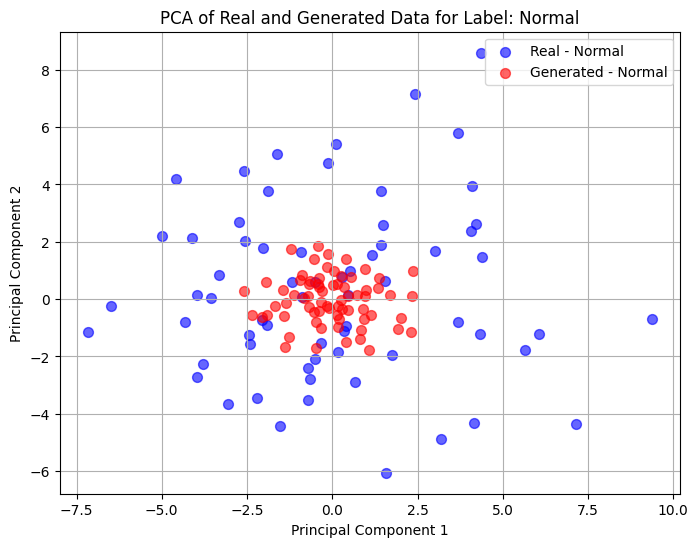

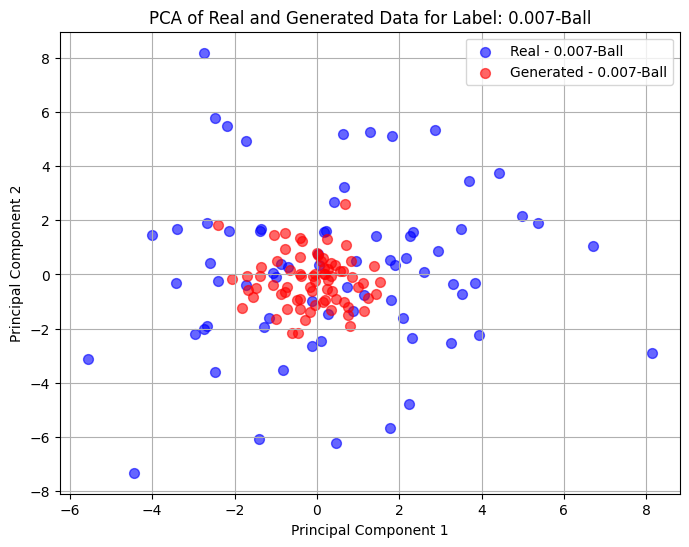

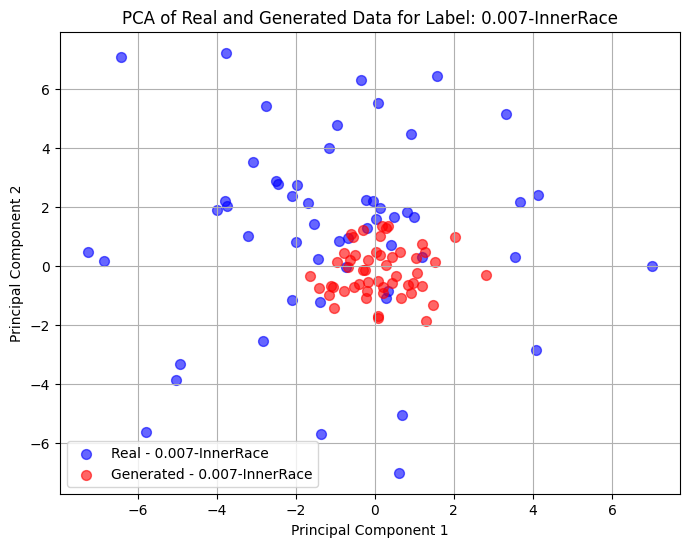

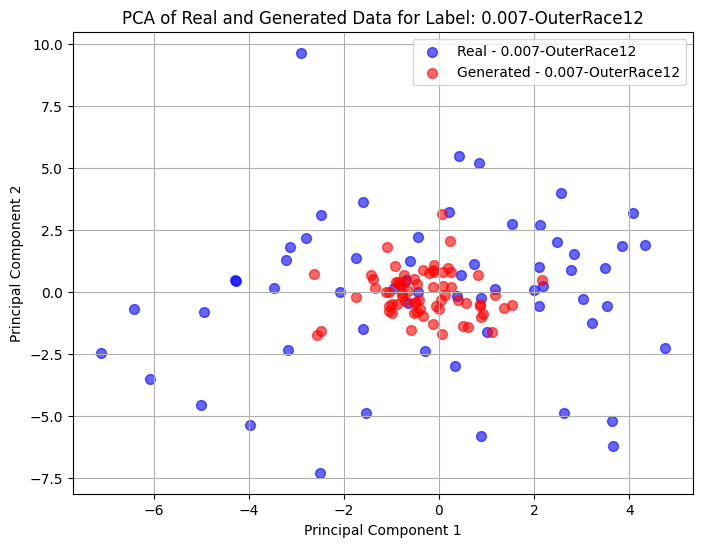

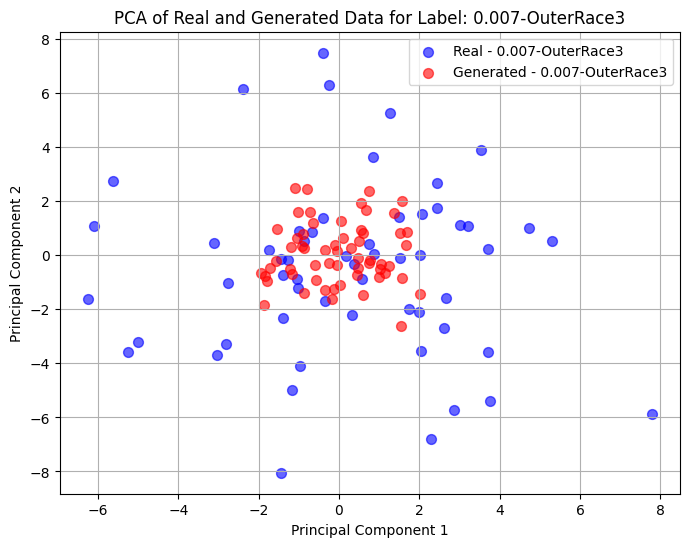

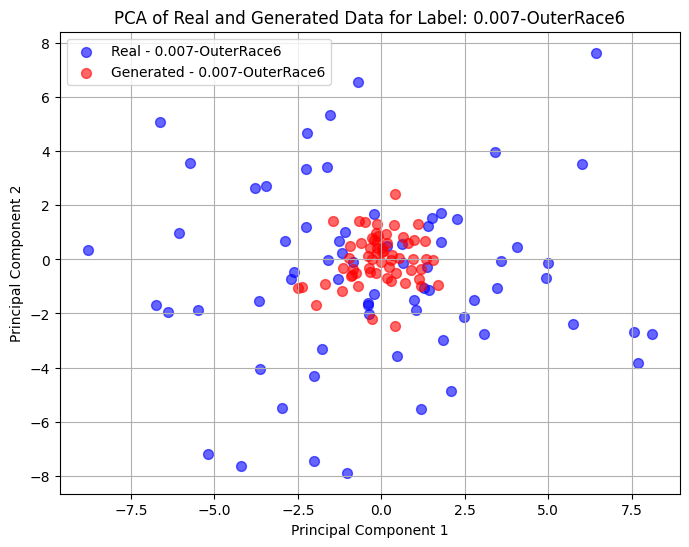

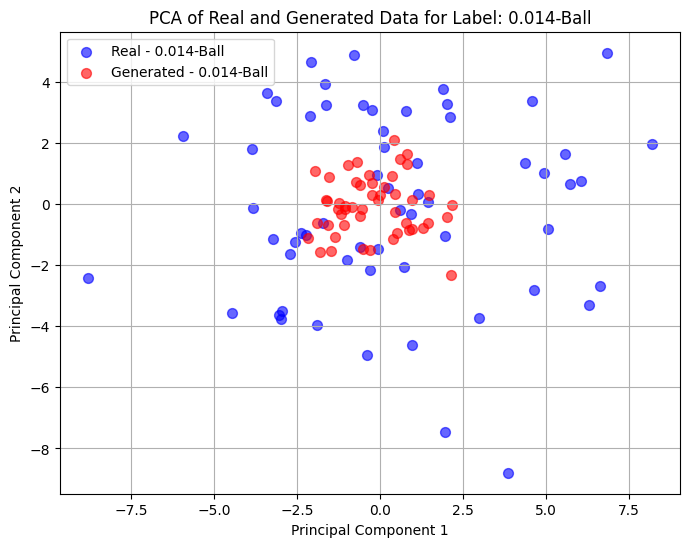

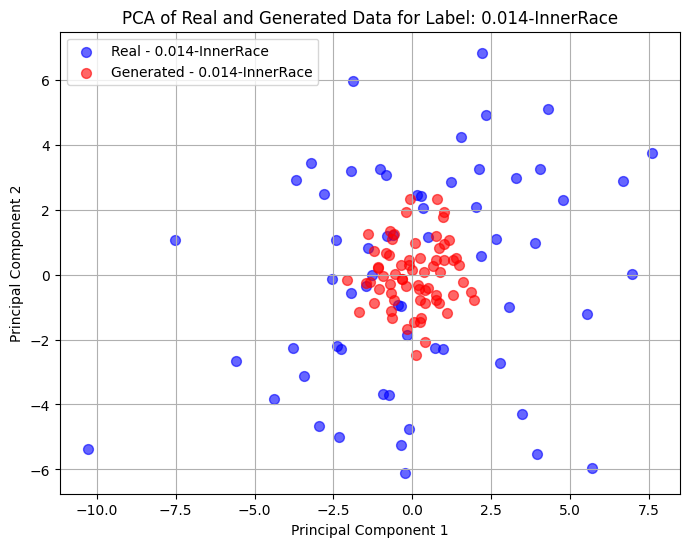

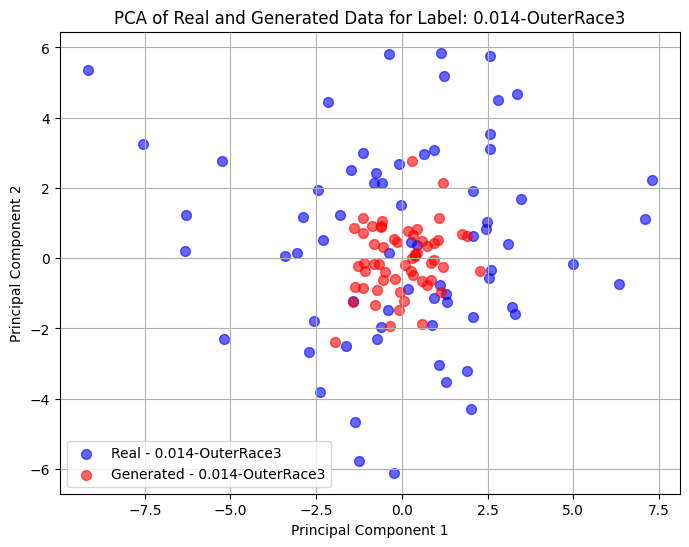

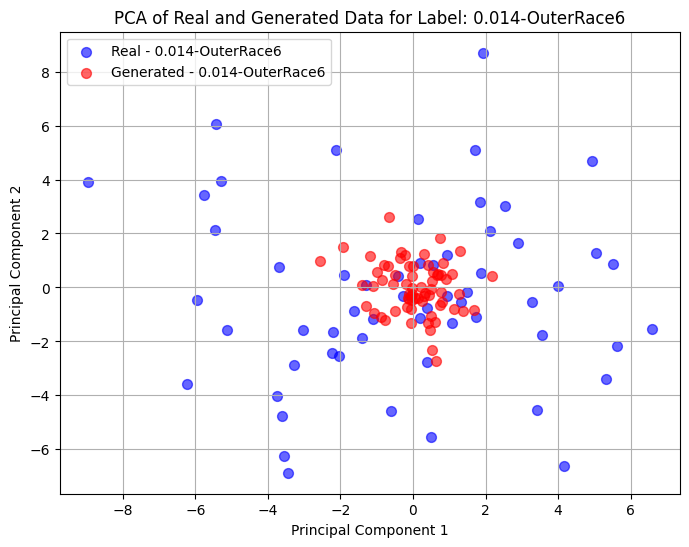

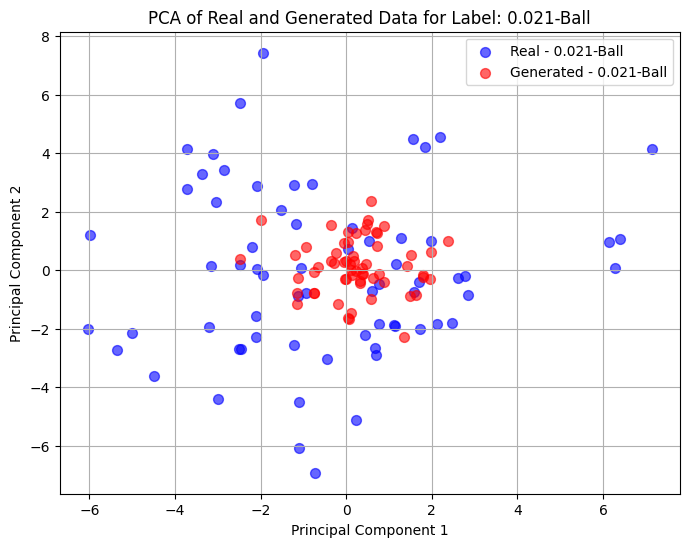

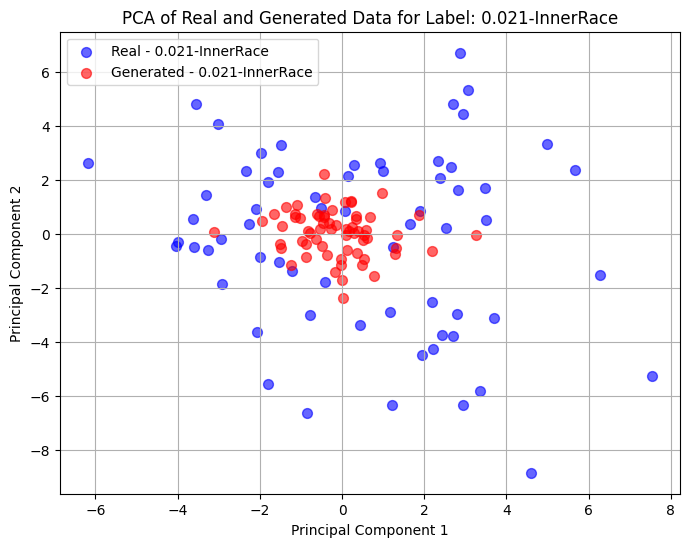

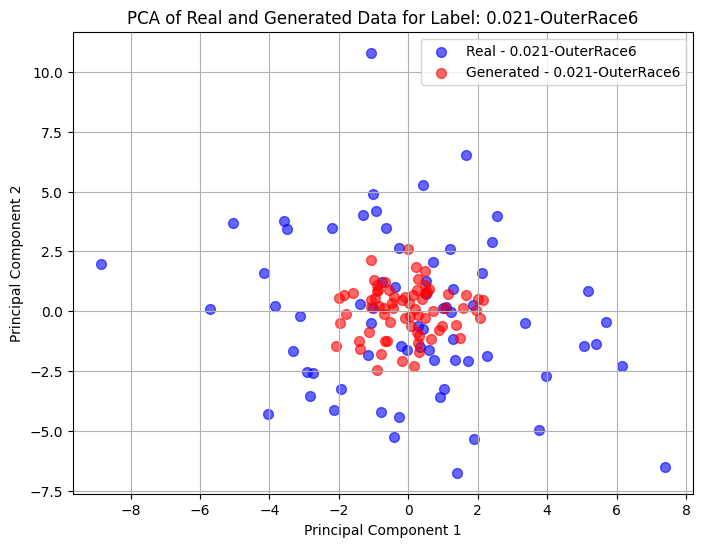

In [9]:
import numpy as np
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Map the string labels to numeric indices
label_mapping = {
    'Normal': 0, '0.007-Ball': 1, '0.007-InnerRace': 2, '0.007-OuterRace12': 3,
    '0.007-OuterRace3': 4, '0.007-OuterRace6': 5, '0.014-Ball': 6, '0.014-InnerRace': 7,
    '0.014-OuterRace3': 8, '0.014-OuterRace6': 9, '0.021-Ball': 10, '0.021-InnerRace': 11,
    '0.021-OuterRace6': 12
}

# Number of unique classes (using the label mapping length)
n_classes = len(label_mapping)

# Example data (replace with actual data)
real_labels = torch.randint(0, n_classes, (826,))  # Simulated real data labels
fake_labels = torch.randint(0, n_classes, (826,))  # Simulated generated data labels
real_data = torch.randn(826, 4096)  # Simulated real data (replace with actual real data)
fake_data = torch.randn(826, 4096)  # Simulated fake data (replace with actual generated data)

# Flatten real and fake data (if necessary) and convert to numpy
real_data_flattened = real_data.reshape(real_data.size(0), -1).cpu().numpy()
fake_data_flattened = fake_data.reshape(fake_data.size(0), -1).cpu().numpy()

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
pca_result_real = pca.fit_transform(real_data_flattened)  # PCA for real data
pca_result_fake = pca.transform(fake_data_flattened)  # Use the same PCA for fake data

# Loop through each label and plot separately
for i in range(n_classes):
    plt.figure(figsize=(8, 6))

    # Separate the real and fake data for the current label
    real_data_label = pca_result_real[real_labels.numpy() == i]
    fake_data_label = pca_result_fake[fake_labels.numpy() == i]

    # Plot real data for the current label
    plt.scatter(real_data_label[:, 0], real_data_label[:, 1], label=f'Real - {list(label_mapping.keys())[i]}', alpha=0.6, color='blue', s=50)

    # Plot fake data for the current label
    plt.scatter(fake_data_label[:, 0], fake_data_label[:, 1], label=f'Generated - {list(label_mapping.keys())[i]}', alpha=0.6, color='red', s=50)

    # Customize the plot for each label
    plt.title(f'PCA of Real and Generated Data for Label: {list(label_mapping.keys())[i]}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


## t-SNE

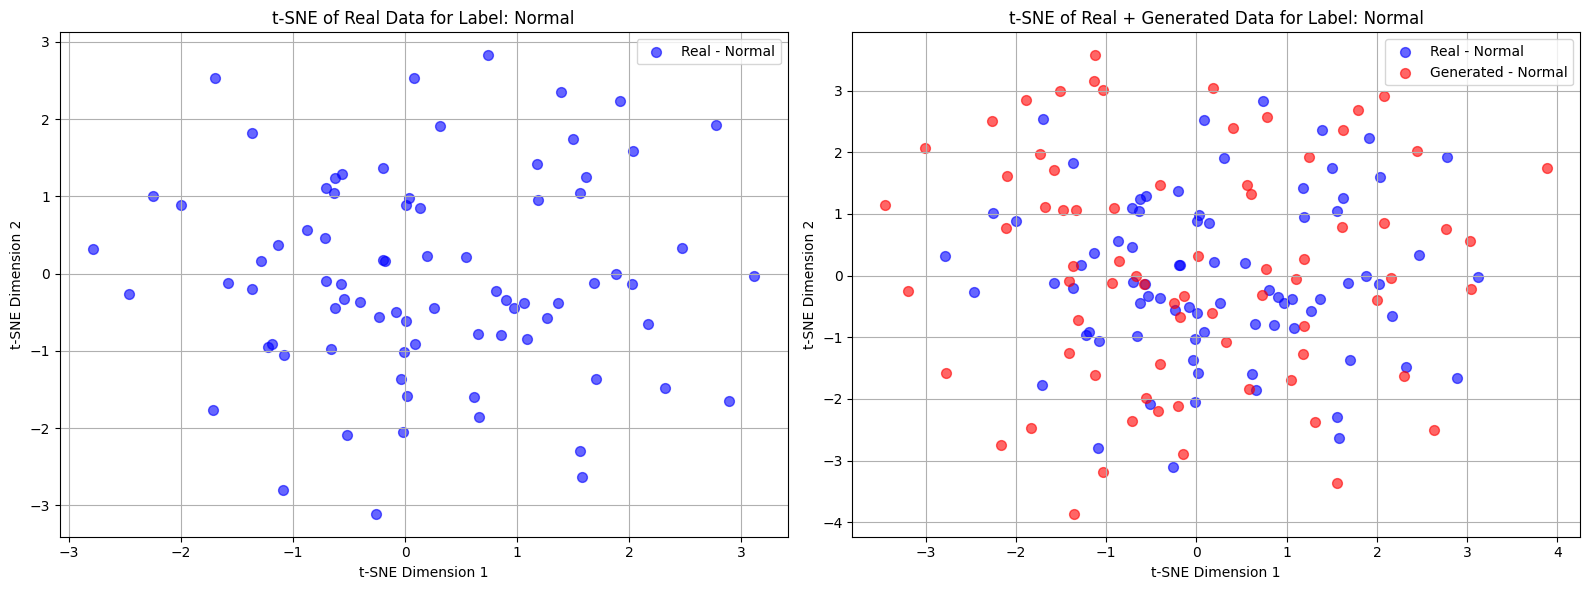

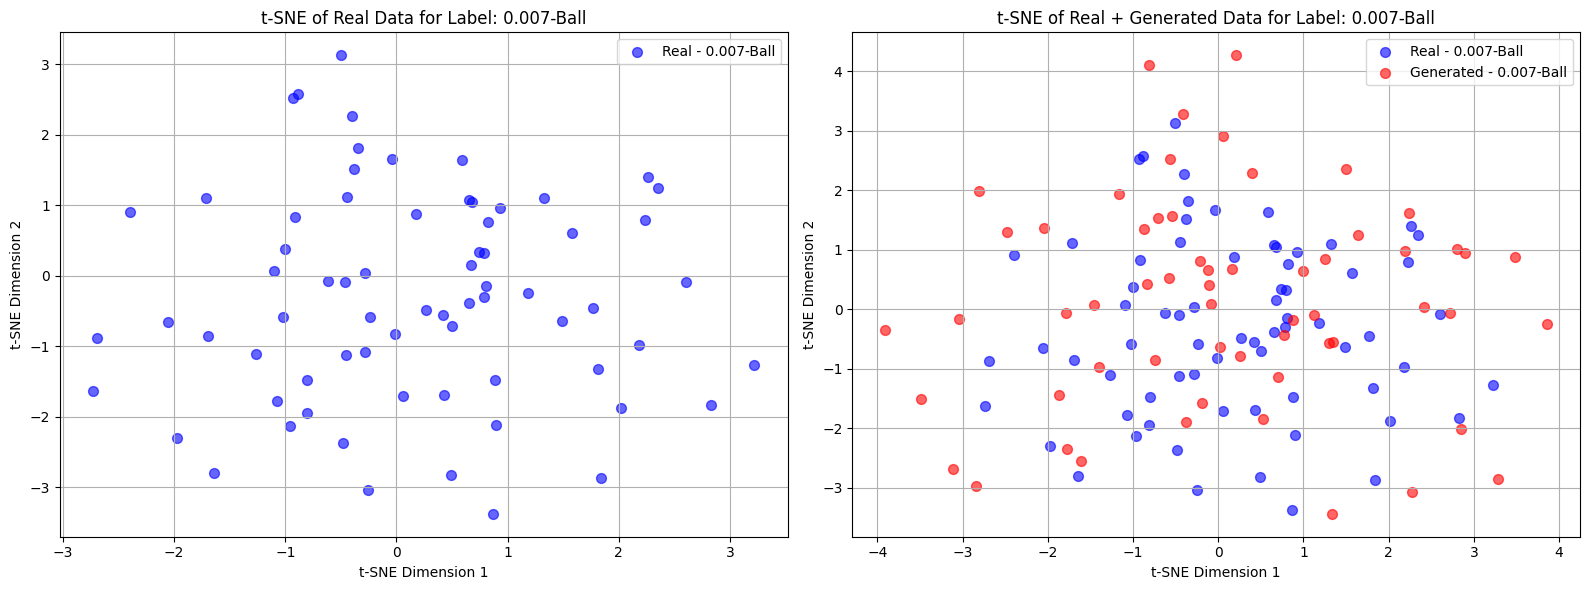

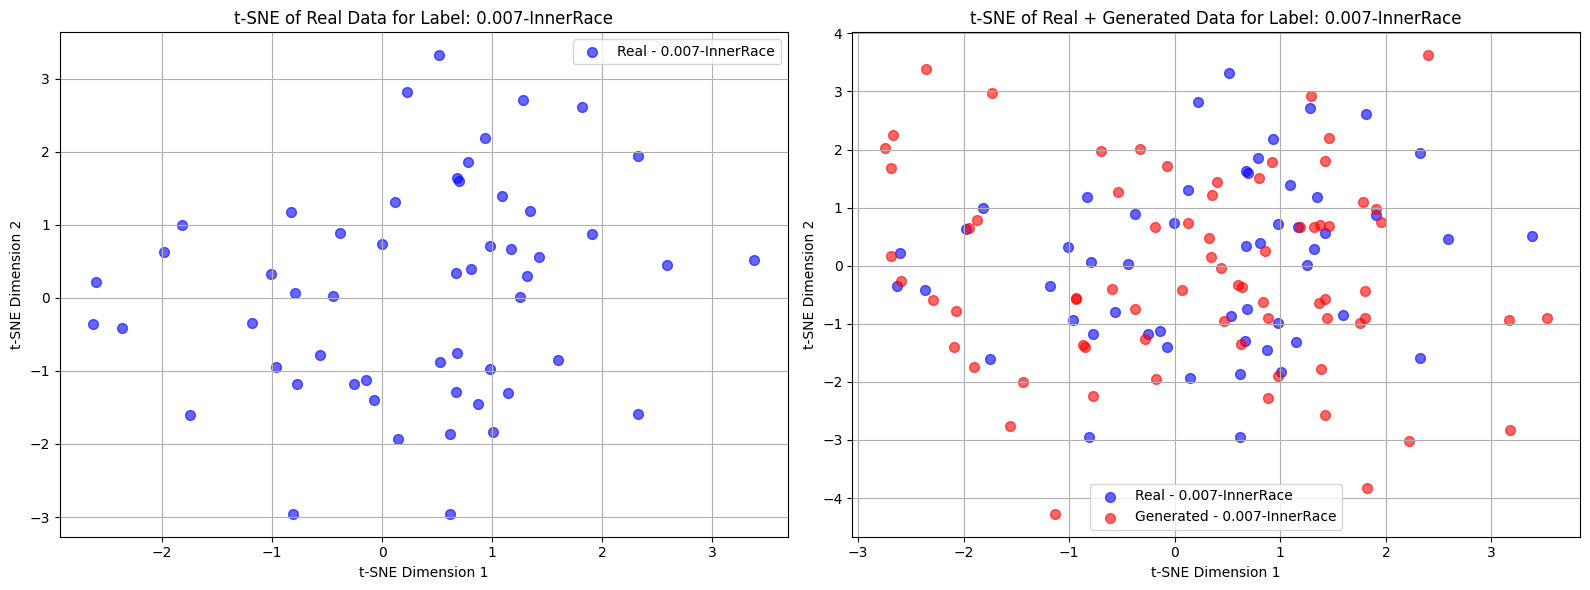

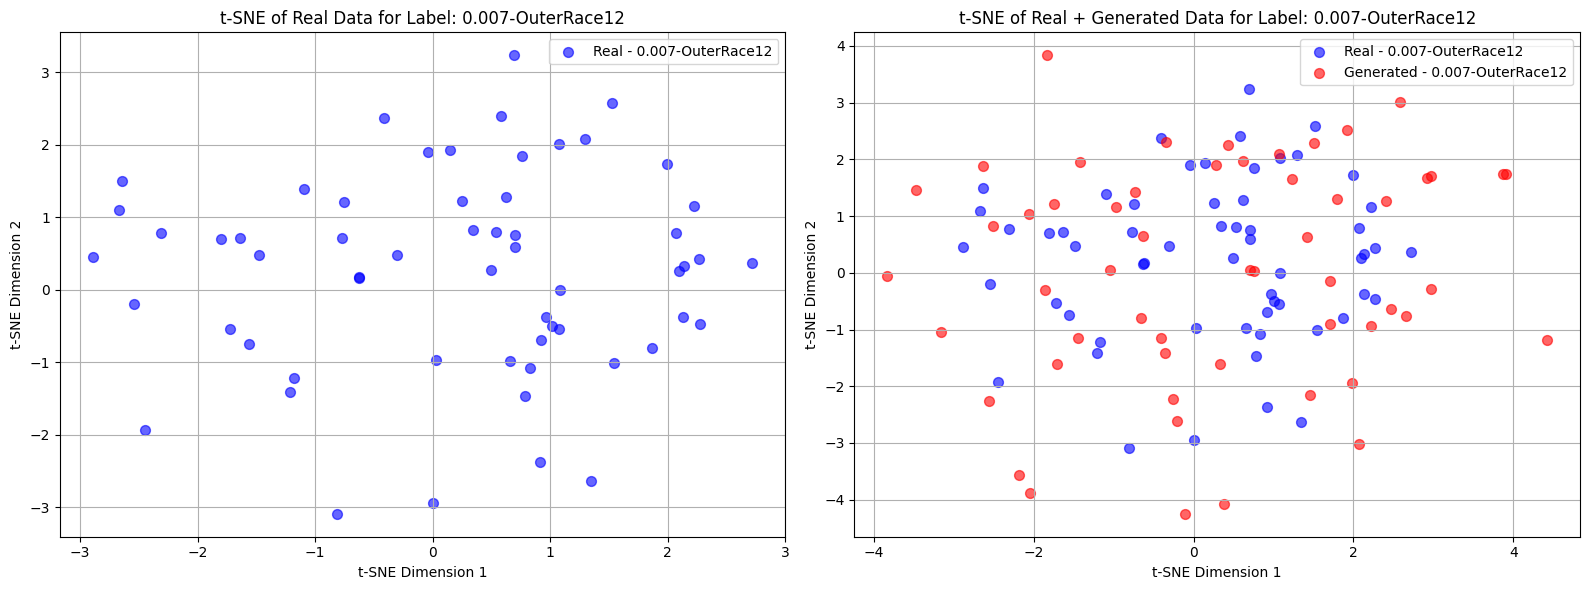

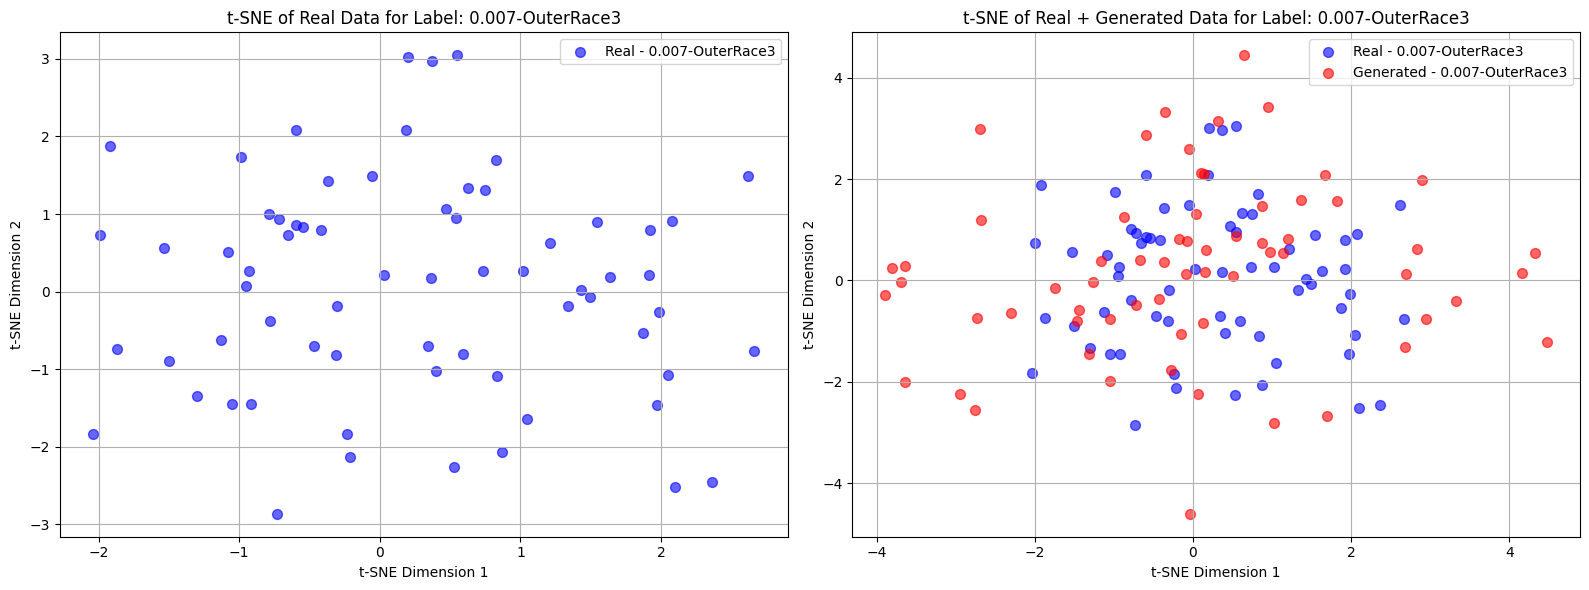

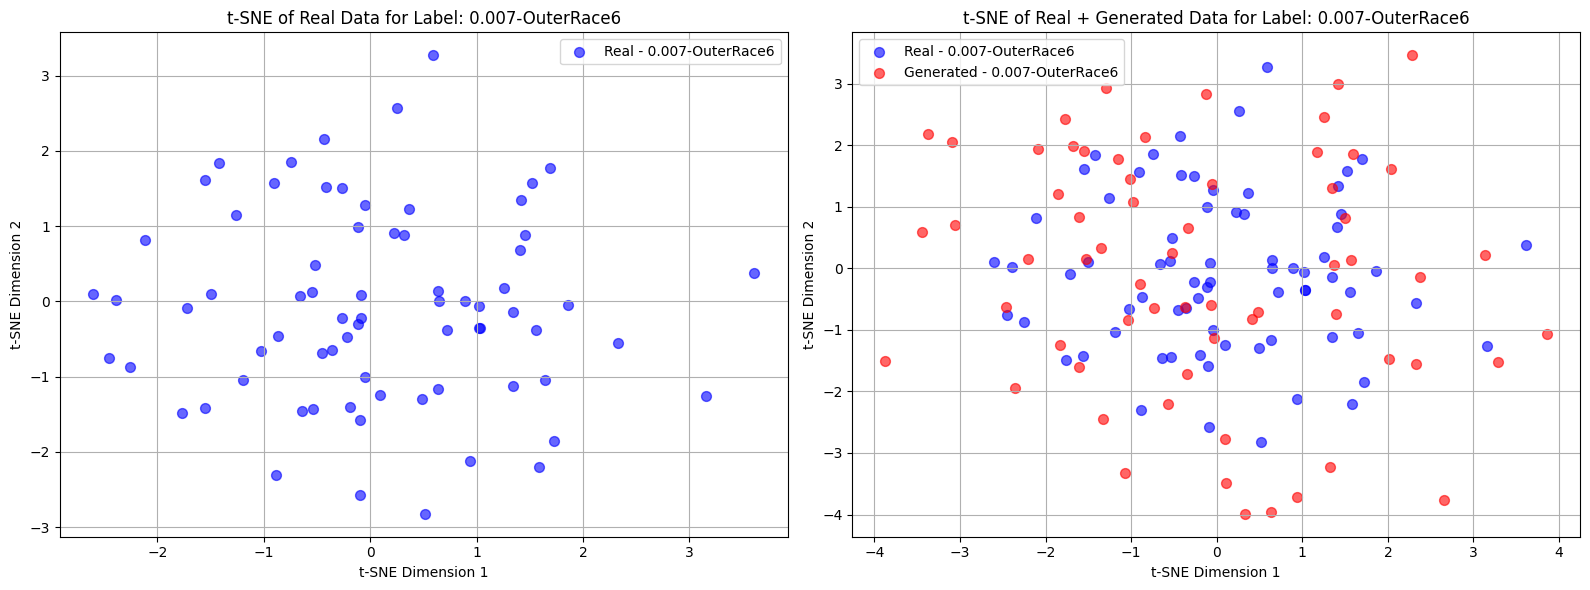

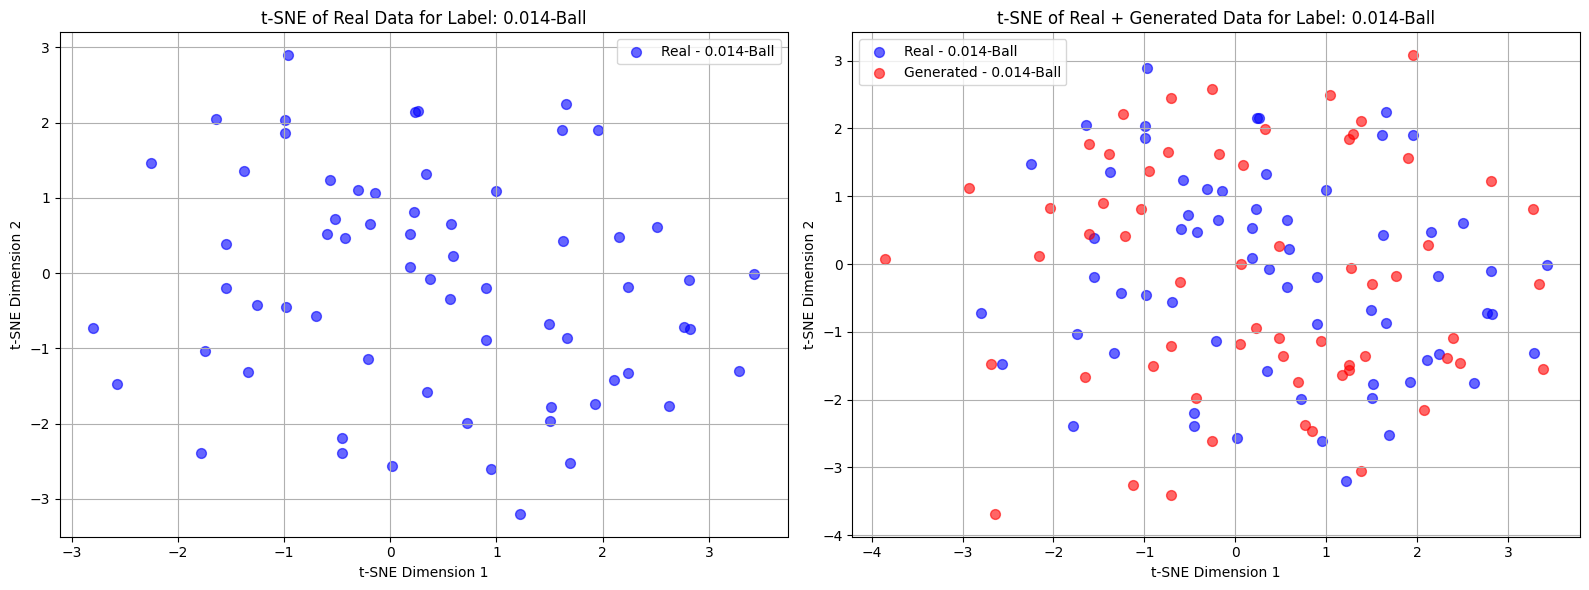

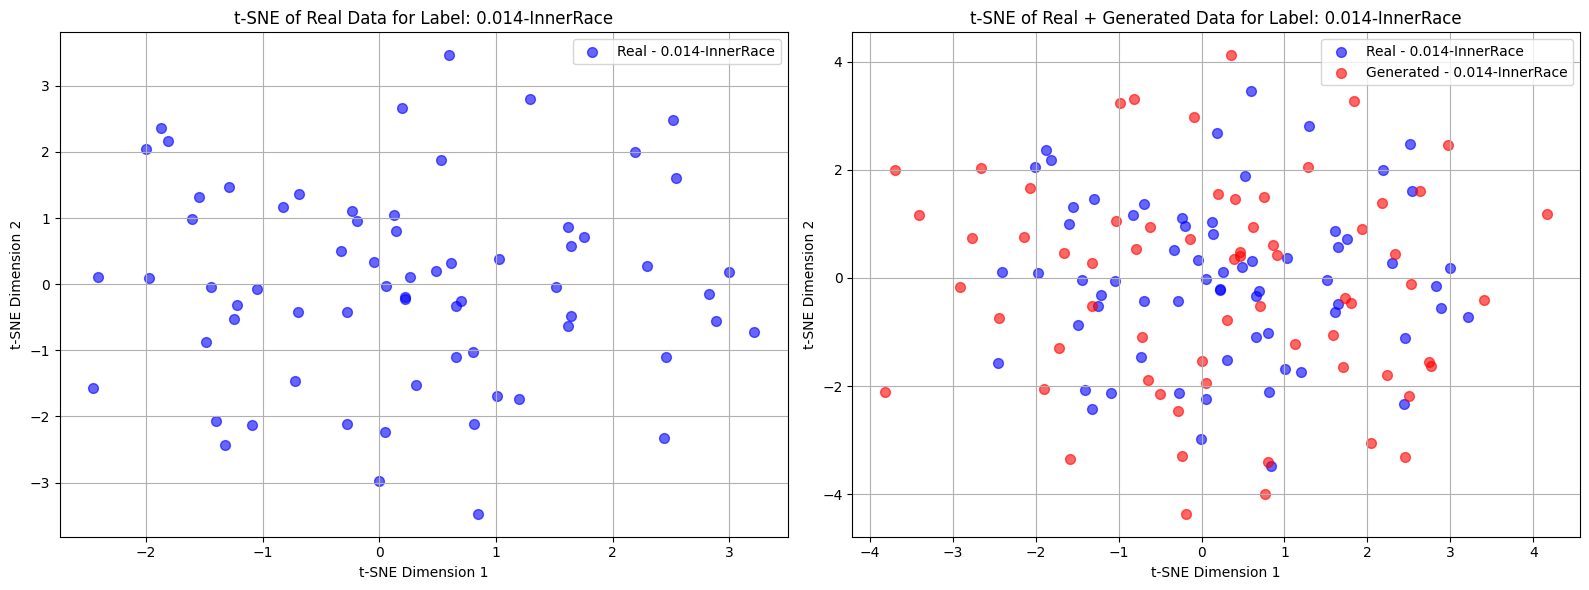

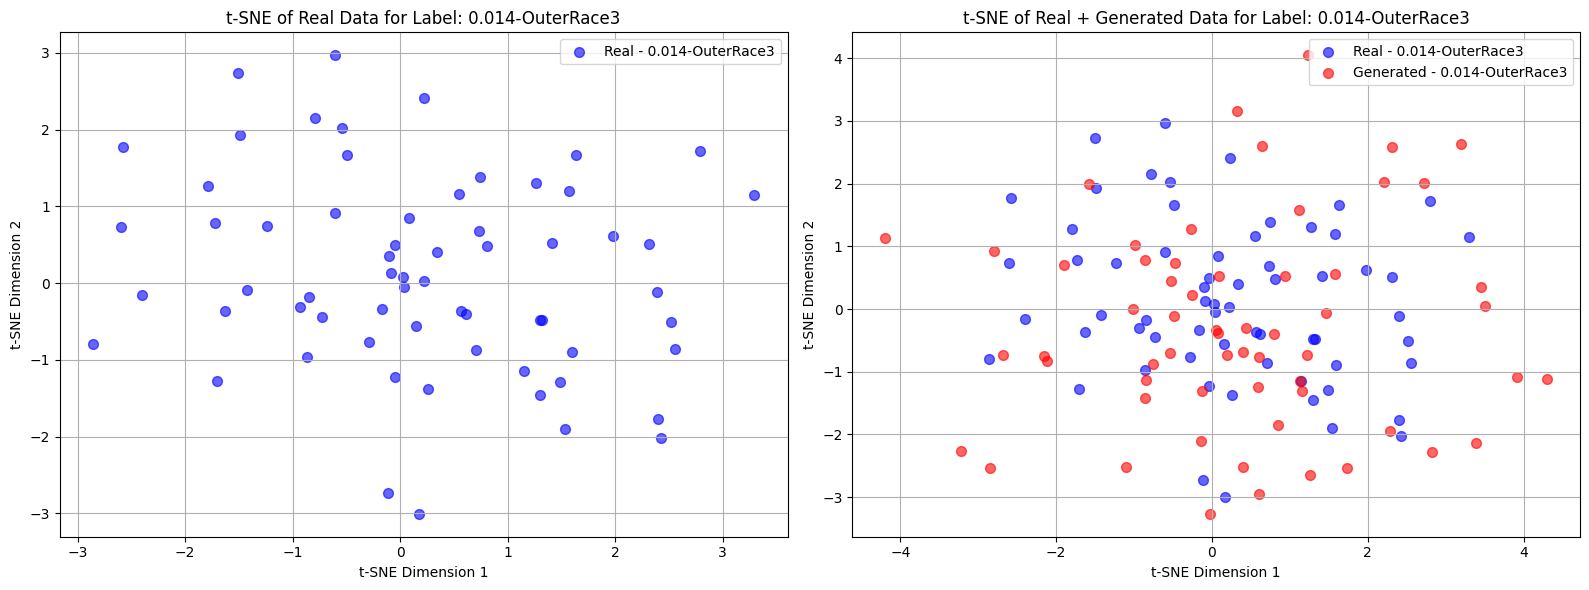

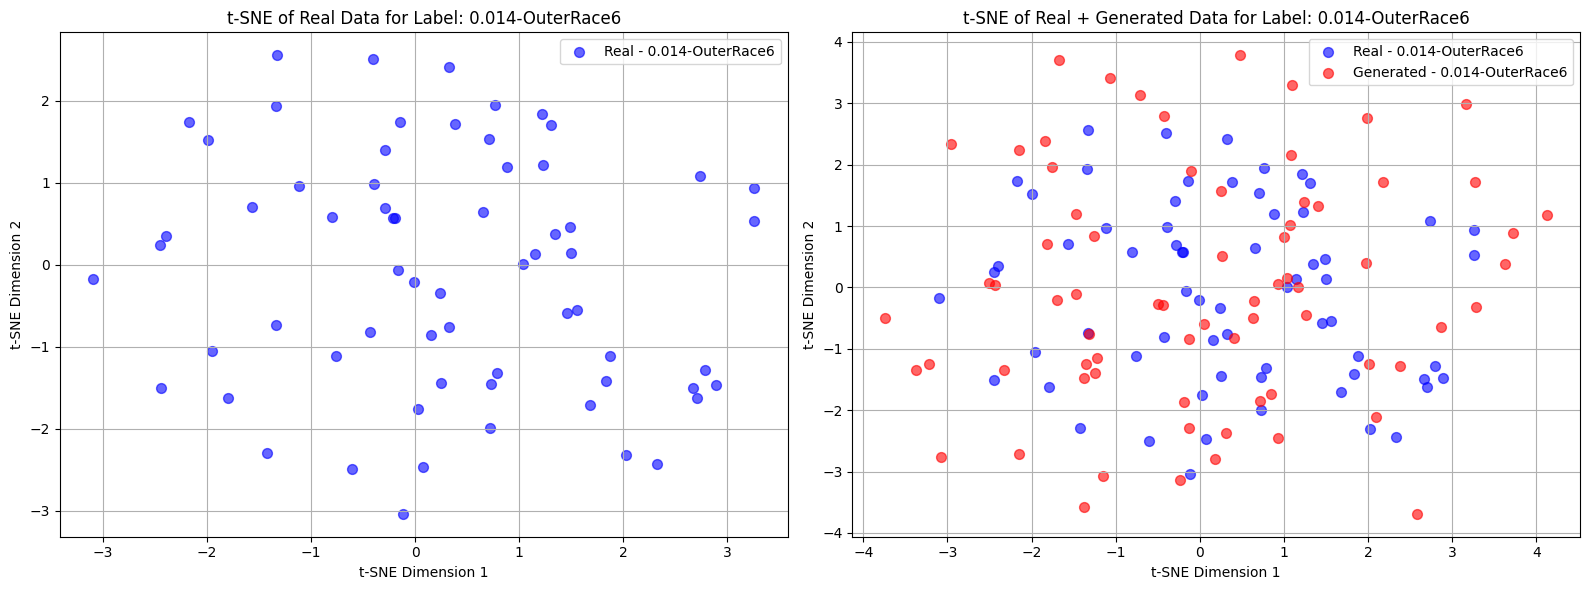

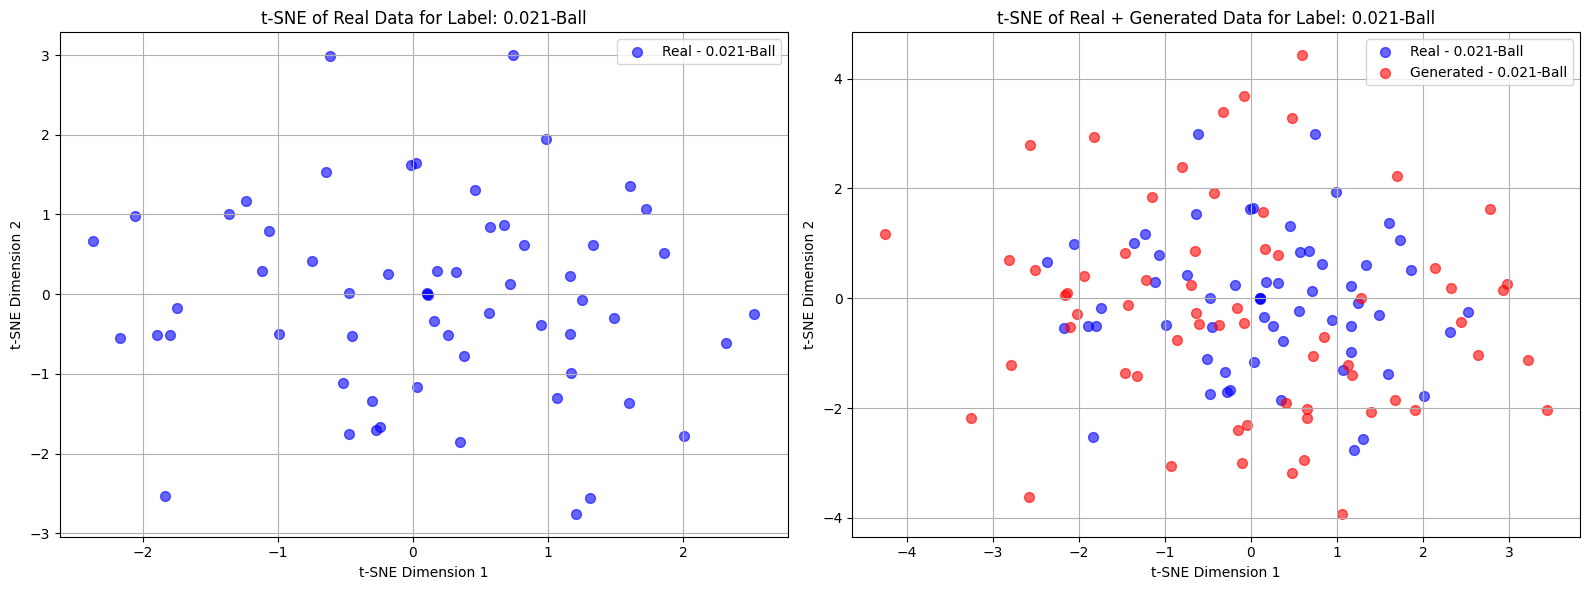

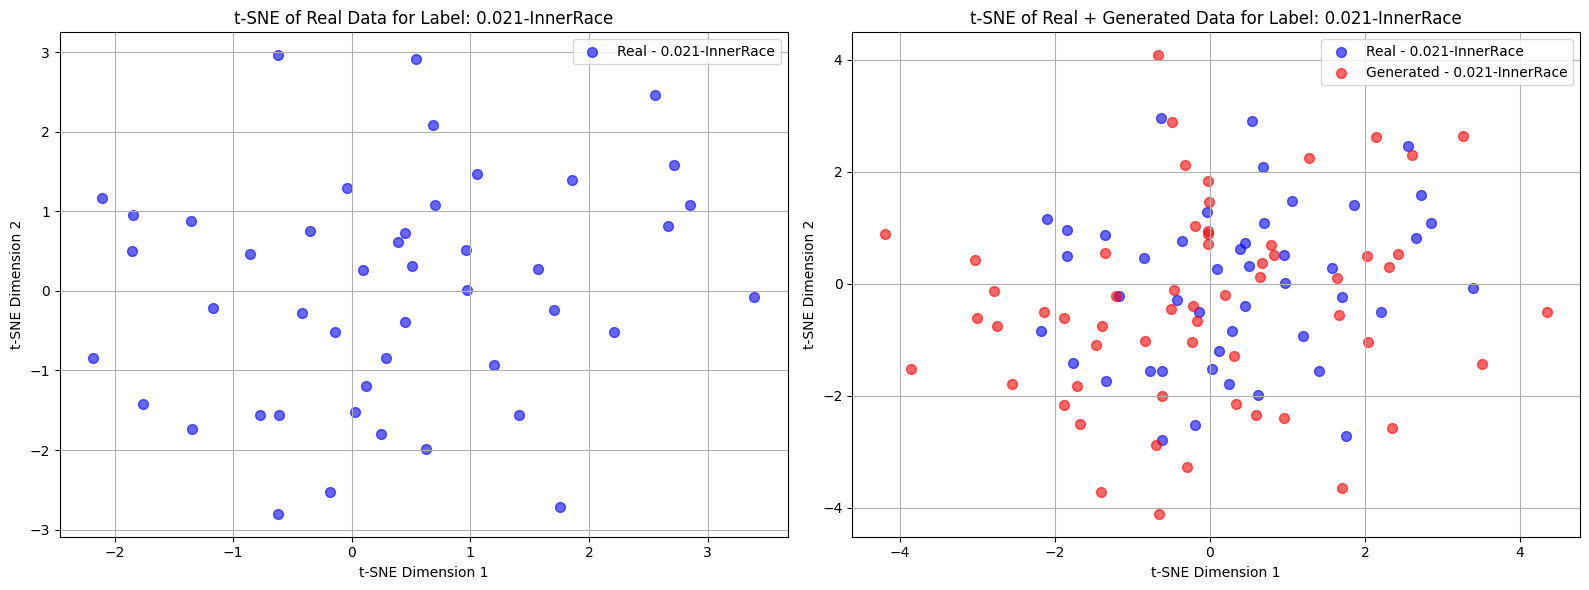

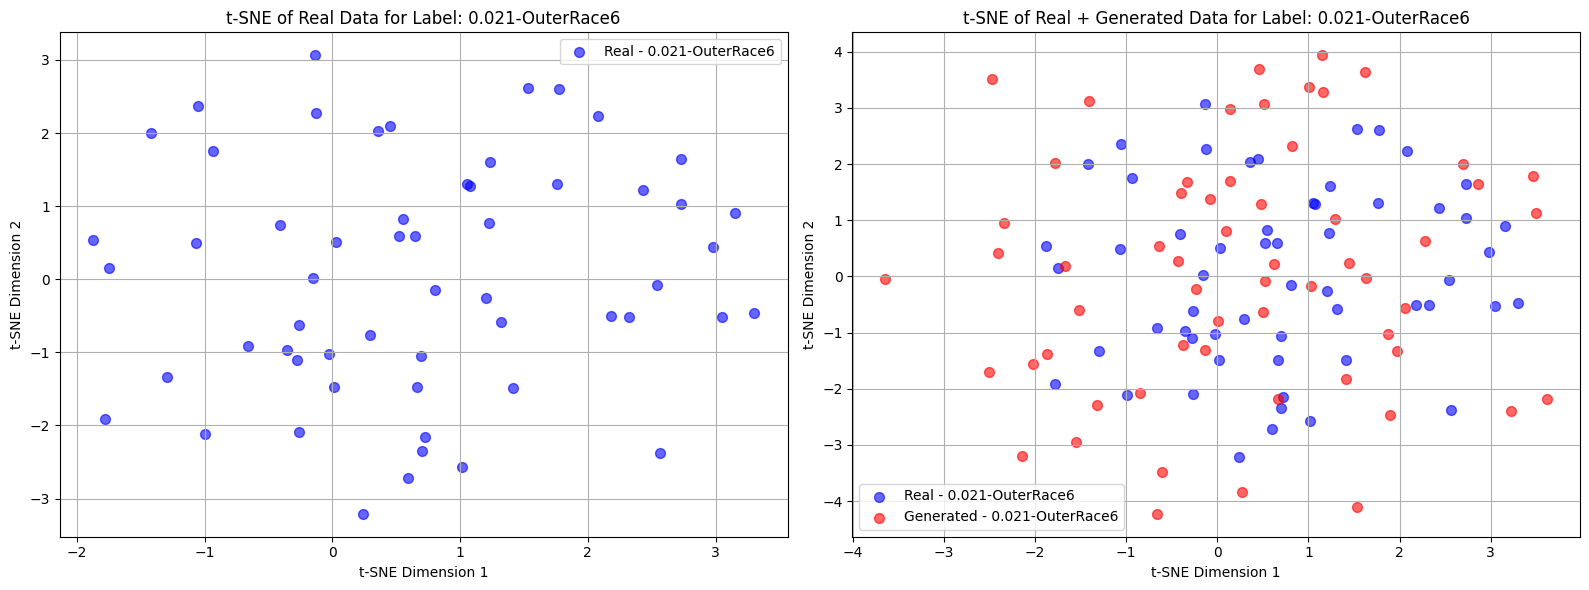

In [10]:
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Map the string labels to numeric indices
label_mapping = {
    'Normal': 0, '0.007-Ball': 1, '0.007-InnerRace': 2, '0.007-OuterRace12': 3,
    '0.007-OuterRace3': 4, '0.007-OuterRace6': 5, '0.014-Ball': 6, '0.014-InnerRace': 7,
    '0.014-OuterRace3': 8, '0.014-OuterRace6': 9, '0.021-Ball': 10, '0.021-InnerRace': 11,
    '0.021-OuterRace6': 12
}

# Number of unique classes (using the label mapping length)
n_classes = len(label_mapping)

# Example data (replace with actual data)
real_labels = torch.randint(0, n_classes, (826,))  # Simulated real data labels
fake_labels = torch.randint(0, n_classes, (826,))  # Simulated generated data labels
real_data = torch.randn(826, 4096)  # Simulated real data (replace with actual real data)
fake_data = torch.randn(826, 4096)  # Simulated fake data (replace with actual generated data)

# Flatten real and fake data (if necessary) and convert to numpy
real_data_flattened = real_data.reshape(real_data.size(0), -1).cpu().numpy()
fake_data_flattened = fake_data.reshape(fake_data.size(0), -1).cpu().numpy()

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
tsne_result_real = tsne.fit_transform(real_data_flattened)  # t-SNE for real data
tsne_result_fake = tsne.fit_transform(fake_data_flattened)  # t-SNE for fake data (using same transformation for consistency)

# Loop through each label and plot separately
for i in range(n_classes):
    plt.figure(figsize=(16, 6))

    # Separate the real and fake data for the current label
    real_data_label = tsne_result_real[real_labels.numpy() == i]
    fake_data_label = tsne_result_fake[fake_labels.numpy() == i]

    # Plot real data for the current label (real data only)
    plt.subplot(1, 2, 1)
    plt.scatter(real_data_label[:, 0], real_data_label[:, 1], label=f'Real - {list(label_mapping.keys())[i]}', alpha=0.6, color='blue', s=50)
    plt.title(f't-SNE of Real Data for Label: {list(label_mapping.keys())[i]}')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True)

    # Plot real + augmented data for the current label (real and generated data)
    plt.subplot(1, 2, 2)
    plt.scatter(real_data_label[:, 0], real_data_label[:, 1], label=f'Real - {list(label_mapping.keys())[i]}', alpha=0.6, color='blue', s=50)
    plt.scatter(fake_data_label[:, 0], fake_data_label[:, 1], label=f'Generated - {list(label_mapping.keys())[i]}', alpha=0.6, color='red', s=50)
    plt.title(f't-SNE of Real + Generated Data for Label: {list(label_mapping.keys())[i]}')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()


## Prediction

In [17]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

# Define input size and number of classes
input_size = 4096  # Size of the input data
num_classes = 5  # Number of classes

# Example data (use your own data here)
real_data = torch.randn(826, 4096)  # Replace with real data
fake_data = torch.randn(826, 4096)  # Replace with augmented data
real_labels = torch.randint(0, 5, (826,))  # Replace with real labels
fake_labels = torch.randint(0, 5, (826,))  # Replace with augmented labels

# Combine real and augmented data
combined_data = torch.cat([real_data, fake_data], dim=0)
combined_labels = torch.cat([real_labels, fake_labels], dim=0)

# Split into train/test sets
train_size = int(0.7 * len(combined_data))
train_data, test_data = combined_data[:train_size], combined_data[train_size:]
train_labels, test_labels = combined_labels[:train_size], combined_labels[train_size:]

# Dataset and DataLoader
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Definitions (same as before)

class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# Define the WDCNN model initialization with input_size
class WDCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(WDCNN, self).__init__()
        
        # Assuming the input size is 4096, and the kernel size is 3
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1)  # 1 channel, 64 output channels
        
        # Calculate the output size of the convolutional layer
        self.conv_output_size = input_size - 3 + 1  # kernel_size=3, stride=1
        
        # Linear layers
        self.fc1 = nn.Linear(self.conv_output_size * 64, 128)  # Flatten the output of the convolution
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Apply convolution
        x = self.conv1(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

class LSTM(nn.Module):
    def __init__(self, feature_size, num_classes, hidden_size=128, num_layers=1):
        super(LSTM, self).__init__()
        # LSTM layer
        self.lstm = nn.LSTM(feature_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, feature_size)
        lstm_out, _ = self.lstm(x)
        # Use the output of the last time step
        final_out = lstm_out[:, -1, :]
        out = self.fc(final_out)
        return out



class BiLSTM(nn.Module):
    def __init__(self, feature_size, num_classes, hidden_size=128, num_layers=1):
        super(BiLSTM, self).__init__()
        # BiLSTM layer (bidirectional=True)
        self.bilstm = nn.LSTM(feature_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Multiply by 2 for bidirectional output

    def forward(self, x):
        # BiLSTM expects input of shape (batch_size, sequence_length, feature_size)
        lstm_out, _ = self.bilstm(x)
        # Use the output of the last time step
        final_out = lstm_out[:, -1, :]
        out = self.fc(final_out)
        return out



# Training and Evaluation Function
def train_and_evaluate(model, train_loader, test_loader, num_classes, model_type):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()

    sequence_length = 128  # Define sequence length
    feature_size = input_size // sequence_length  # Calculate feature size

    # Training Loop
    for epoch in range(10):  # Number of epochs
        for inputs, labels in train_loader:
            # Reshape based on model type
            if model_type == "MLP":
                inputs = inputs.view(inputs.size(0), -1)  # Flatten for MLP
            elif model_type == "WDCNN":
                inputs = inputs.unsqueeze(1)  # Add channel dimension for CNN
            elif model_type in ["LSTM", "BiLSTM"]:
                inputs = inputs.view(inputs.size(0), sequence_length, feature_size)  # Reshape for LSTM/BiLSTM
            else:
                raise ValueError(f"Unknown model type: {model_type}")

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Reshape inputs for evaluation
            if model_type == "MLP":
                inputs = inputs.view(inputs.size(0), -1)  # Flatten for MLP
            elif model_type == "WDCNN":
                inputs = inputs.unsqueeze(1)  # Add channel dimension for CNN
            elif model_type in ["LSTM", "BiLSTM"]:
                inputs = inputs.view(inputs.size(0), sequence_length, feature_size)  # Reshape for LSTM/BiLSTM

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    f1 = f1_score(y_true, y_pred, average="macro")
    return accuracy, precision, recall, f1


# Initialize a list to store results
results = []

# Define sequence length and feature size
sequence_length = 128  # Number of timesteps
feature_size = input_size // sequence_length  # Calculate feature size for LSTM/BiLSTM

# Models dictionary
models = {
    "MLP": MLP(input_size=input_size, num_classes=num_classes),
    "WDCNN": WDCNN(input_size=input_size, num_classes=num_classes),
    "LSTM": LSTM(feature_size=input_size // sequence_length, num_classes=num_classes),
    "BiLSTM": BiLSTM(feature_size=input_size // sequence_length, num_classes=num_classes),
}



# Evaluation loop for different models and data types
for model_name, model in models.items():
    for data_type in ["Original", "Augmented"]:
        if data_type == "Original":
            train_loader = DataLoader(TensorDataset(real_data, real_labels), batch_size=32, shuffle=True)
            test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=32, shuffle=False)
        else:
            train_loader = DataLoader(TensorDataset(fake_data, fake_labels), batch_size=32, shuffle=True)
            test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=32, shuffle=False)

        # Evaluate the model
        accuracy, precision, recall, f1 = train_and_evaluate(
            model, train_loader, test_loader, num_classes, model_type=model_name
        )

        results.append({
            "Model": model_name,
            "Data Type": data_type,
            "Accuracy": f"{accuracy*100:.2f}%",
            "Precision": f"{precision*100:.2f}%",
            "Recall": f"{recall*100:.2f}%",
            "F1-score": f"{f1*100:.2f}%"
        })

# Convert results to DataFrame and print
df = pd.DataFrame(results)
print(df)


    Model  Data Type Accuracy Precision   Recall F1-score
0     MLP   Original   19.96%    20.01%   20.30%   19.72%
1     MLP  Augmented  100.00%   100.00%  100.00%  100.00%
2   WDCNN   Original   20.36%    20.16%   20.36%   20.17%
3   WDCNN  Augmented  100.00%   100.00%  100.00%  100.00%
4    LSTM   Original   20.56%    22.44%   20.93%   20.61%
5    LSTM  Augmented   83.06%    83.22%   82.38%   82.54%
6  BiLSTM   Original   22.38%    22.46%   22.24%   21.73%
7  BiLSTM  Augmented   83.06%    82.79%   82.77%   82.72%
